In [9]:
import argparse
import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors


## Tools and Functions

In [10]:

class Environment:
    def __init__(self, n, actions, rewards, e_x=[0, 3], e_y=[0, 3]):
        self.n = n
        self.actions = actions
        self.rewards = rewards
        self.e_x1, self.e_x2 = e_x
        self.e_y1, self.e_y2 = e_y


def policy_iteration(n, v0_val, gamma, theta):
    """Runs a simulation of the Policy Iteration (prediction + control) algorithm

    Args:
        n (int): length and width of the grid
        v0_val (int): initial value for the value function
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
    """

    # Create initial environment
    env = build_grid(n)
    i = 0
    plot_grid(env)

    # Generate initial value function and policy
    v = get_init_v(n, v0_val, env.e_x1, env.e_y1)
    v = get_init_v(n, v0_val, env.e_x2, env.e_y2)
    pi = get_equiprobable_policy(n)

    # Plot initial value function and policy
    plot_v_values(v, env.n)
    plot_optimal_actions(env, pi)

    policy_stable = False
    while not policy_stable:
        i += 1
        print("\nIteration {} of Policy Iteration algorithm".format(i))
        # Run the policy evaluation
        policy_evaluation(env, v, pi, gamma, theta)
        # Run the policy improvement algorithm
        policy_stable = policy_improvement(env, v, pi, gamma)
        plot_optimal_actions(env, pi)

    print("\nPolicy Iteration algorithm converged after {} steps".format(i))


def value_update_optimal(Value, gamma):
    New_Value = np.zeros(16)
    for cell in range(1, 15):
        for action in range(4):
            if action == 0:
                New_Value_action_0 = (
                    (-1 + gamma * Value[cell - 4])
                    if cell > 3
                    else (-1 + gamma * Value[cell])
                )
            elif action == 1:
                New_Value_action_1 = (
                    (-1 + gamma * Value[cell + 4])
                    if cell < 12
                    else (-1 + gamma * Value[cell])
                )
            elif action == 2:
                New_Value_action_2 = (
                    (-1 + gamma * Value[cell - 1])
                    if cell % 4 != 0
                    else (-1 + gamma * Value[cell])
                )
            elif action == 3:
                New_Value_action_3 = (
                    (-1 + gamma * Value[cell + 1])
                    if cell % 4 != 3
                    else (-1 + gamma * Value[cell])
                )
        New_Value[cell] = np.max(
            [
                New_Value_action_0,
                New_Value_action_1,
                New_Value_action_2,
                New_Value_action_3,
            ]
        )
    return New_Value


def policy_evaluation(env, v, pi, gamma, theta):
    """Applies the policy evaluation algorithm.

    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
    """

    delta = theta + 1
    iter = 0

    while delta >= theta:
        old_v = v.copy()
        delta = 0

        # Traverse all states
        for x in range(env.n):
            for y in range(env.n):
                # Run one iteration of the Bellman update rule for the value function
                bellman_update(env, v, old_v, x, y, pi, gamma)
                # Compute difference
                delta = max(delta, abs(old_v[x, y] - v[x, y]))

        iter += 1

    # Plot new value function
    plot_v_values(v, env.n)
    print(
        "\nThe Policy Evaluation algorithm converged after {} iterations".format(iter)
    )


def policy_improvement(env, v, pi, gamma):
    """Applies the Policy Improvement step.

    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """

    policy_stable = True

    # Iterate states
    for x in range(env.n):
        for y in range(env.n):
            old_pi = pi[x, y, :].copy()

            # Iterate all actions
            best_actions = []
            max_v = None
            for a in env.actions:
                # Compute next state
                s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)
                # Get value
                curr_val = (
                    env.rewards[s_prime_x, s_prime_y] + gamma * v[s_prime_x, s_prime_y]
                )

                if max_v is None:
                    max_v = curr_val
                    best_actions.append(a)
                elif curr_val > max_v:
                    max_v = curr_val
                    best_actions = [a]
                elif curr_val == max_v:
                    best_actions.append(a)

            # Define new policy
            define_new_policy(pi, x, y, best_actions, env.actions)

            # Check whether the policy has changed
            if not (old_pi == pi[x, y, :]).all():
                policy_stable = False

    return policy_stable


def bellman_update(env, v, old_v, x, y, pi, gamma):
    """Applies the Bellman update rule to the value function

    Args:
        env (Environment): grid world environment
        v (array): numpy array representing the value function
        old_v (array): numpy array representing the value function on the last iteration
        x (int): x value position of the current state
        y (int): y value position of the current state
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """

    # The value function on the terminal state always has value 0
    if x == env.e_x1 and y == env.e_y1:
        return None
    if x == env.e_x2 and y == env.e_y2:
        return None

    total = 0

    for a in env.actions:
        # Get next state
        s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)

        total += pi[x, y, a] * (
            env.rewards[s_prime_x, s_prime_y] + gamma * old_v[s_prime_x, s_prime_y]
        )

    # Update the value function
    v[x, y] = total


def define_new_policy(pi, x, y, best_actions, actions):
    """Defines a new policy given the new best actions.

    Args:
        pi (array): numpy array representing the policy
        x (int): x value position of the current state
        y (int): y value position of the current state
        best_actions (list): list with best actions
        actions (list): list of every possible action
    """

    prob = 1 / len(best_actions)

    for a in actions:
        pi[x, y, a] = prob if a in best_actions else 0


def build_grid(n):
    """Build an NxN grid with start and end cells, as well as some barrier cells.

    Args:
        n (int): length and width of the grid

    Returns:
        env (Environment): grid world environment
    """

    # Define set of possible actions: go left (0), up (1), right (2) or down (4)
    actions = [0, 1, 2, 3]

    # Define barrier cells -> these will have barrier reward. All other have -1 reward
    rewards = (-1) * np.ones((n, n))

    # Create environment
    env = Environment(n, actions, rewards)

    return env


def get_next_state(x, y, a, n):
    """Computes next state from current state and action.

    Args:
        x (int): x value of the current state
        y (int): y value of the current state
        a (int): action
        n (int): length and width of the grid

    Returns:
        s_prime_x (int): x value of the next state
        s_prime_y (int): y value of the next state
    """

    # Compute next state according to the action
    if a == 0:
        s_prime_x = x
        s_prime_y = max(0, y - 1)
    elif a == 1:
        s_prime_x = max(0, x - 1)
        s_prime_y = y
    elif a == 2:
        s_prime_x = x
        s_prime_y = min(n - 1, y + 1)
    else:
        s_prime_x = min(n - 1, x + 1)
        s_prime_y = y

    return s_prime_x, s_prime_y


def get_init_v(n, v0, e_x, e_y):
    """Defines initial value function v_0

    Args:
        n (int): length and width of the grid
        v0 (float): initial value for the value function (equal for every state)
        e_x (int): x value of the end cell
        e_y (int): y value of the end cell

    Returns:
        v0 (array): initial value function
    """

    v0 = v0 * np.ones((n, n))

    # Value function of terminal state must be 0
    v0[e_x, e_y] = 0

    return v0


def get_equiprobable_policy(n):
    """Defines the equiprobable policy. Policy is a matrix s.t.
        pi[x, y, a] = Pr[A = a | S = (x,y)]

    Actions are:
        * 0: go left
        * 1: go up
        * 2: go right
        * 3: go down

    Args:
        n (int): length and width of the grid

    Returns:
        pi (array): numpy array representing the equiprobably policy
    """

    pi = 1 / 4 * np.ones((n, n, 4))
    return pi


def plot_grid(env):
    """Plot grid

    Args:
        env (Environment): grid world environment
    """

    data = env.rewards.copy()
    data[env.e_x1, env.e_y1] = 10
    data[env.e_x2, env.e_y2] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(["grey", "white", "red"])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which="major", axis="both", linestyle="-", color="k", linewidth=2)
    ax.set_xticks(np.arange(-0.5, env.n, 1))
    ax.set_yticks(np.arange(-0.5, env.n, 1))

    plt.show()


def plot_v_values(v, n):
    """Plots the value function in each state as a grid.

    Args:
        v (array): numpy array representing the value function
        n (int):
    """

    fig, ax = plt.subplots()
    im = ax.imshow(v, cmap="YlOrBr", interpolation="nearest")

    # draw gridlines
    ax.grid(which="major", axis="both", linestyle="-", color="k", linewidth=2)
    ax.set_xticks(np.arange(-0.5, n, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(n):
        for j in range(n):
            text = ax.text(
                j, i, "{:.2f}".format(v[i, j]), ha="center", va="center", color="black"
            )

    ax.set_title("Value function")
    fig.tight_layout()
    plt.show()


def plot_optimal_actions(env, pi):
    """Plots the optimal action to take in each state

    Args:
        env (Environment): grid world environment
        pi (array): numpy array indicating the probability of taking each action in each state
    """

    data = env.rewards.copy()
    data[env.e_x1, env.e_y1] = 10
    data[env.e_x2, env.e_y2] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(["grey", "white", "red"])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which="major", axis="both", linestyle="-", color="k", linewidth=2)
    ax.set_xticks(np.arange(-0.5, env.n, 1))
    ax.set_yticks(np.arange(-0.5, env.n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(env.n):
        for j in range(env.n):
            arrow = get_arrow(pi[i, j, :])
            text = ax.text(
                j, i, arrow, fontsize=16, ha="center", va="center", color="black"
            )

    ax.set_title("Policy")
    fig.tight_layout()
    plt.show()


def get_arrow(prob_arr):
    """Returns the arrows that represent the highest probability actions.

    Args:
        prob_arr (array): numpy array denoting the probability of taking each action on a given state

    Returns:
        arrow (str): string denoting the most probable action(s)
    """

    best_actions = np.where(prob_arr == np.amax(prob_arr))[0]
    if len(best_actions) == 1:
        if 0 in best_actions:
            return r"$\leftarrow$"
        if 1 in best_actions:
            return r"$\uparrow$"
        if 2 in best_actions:
            return r"$\rightarrow$"
        else:
            return r"$\downarrow$"

    elif len(best_actions) == 2:
        if 0 in best_actions and 1 in best_actions:
            return r"$\leftarrow \uparrow$"
        elif 0 in best_actions and 2 in best_actions:
            return r"$\leftrightarrow$"
        elif 0 in best_actions and 3 in best_actions:
            return r"$\leftarrow \downarrow$"
        elif 1 in best_actions and 2 in best_actions:
            return r"$\uparrow \rightarrow$"
        elif 1 in best_actions and 3 in best_actions:
            return r"$\updownarrow$"
        elif 2 in best_actions and 3 in best_actions:
            return r"$\downarrow \rightarrow$"

    elif len(best_actions) == 3:
        if 0 not in best_actions:
            return r"$\updownarrow \rightarrow$"
        elif 1 not in best_actions:
            return r"$\leftrightarrow \downarrow$"
        elif 2 not in best_actions:
            return r"$\leftarrow \updownarrow$"
        else:
            return r"$\leftrightarrow \uparrow$"

    else:
        return r"$\leftrightarrow \updownarrow$"


## Policy Iteration (Iteration number: 4)

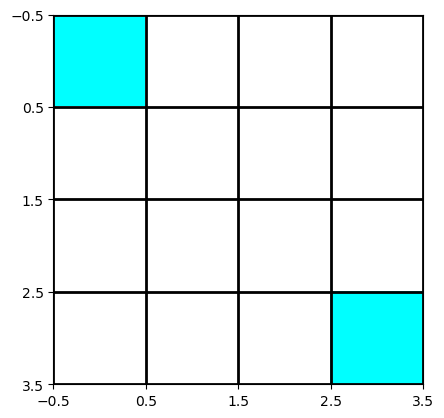

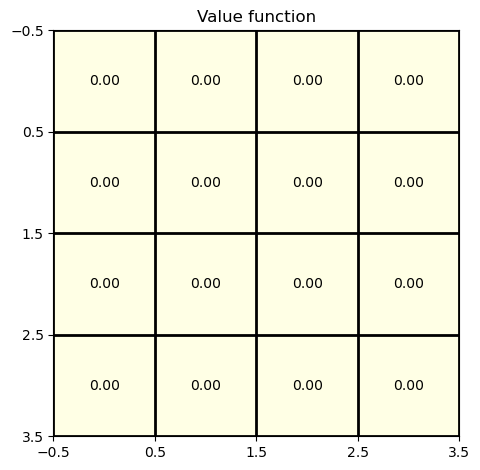

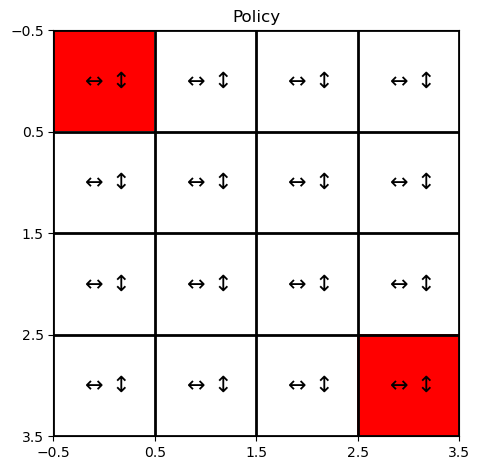


Iteration 1 of Policy Iteration algorithm


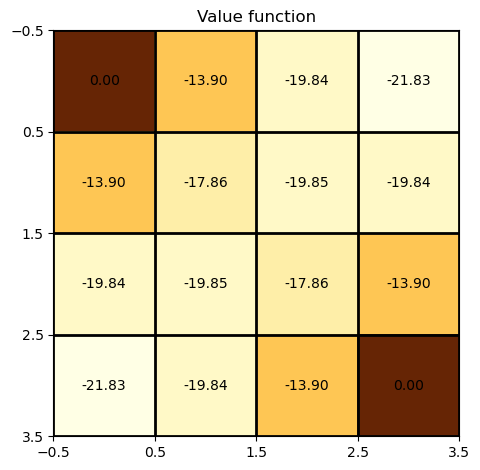


The Policy Evaluation algorithm converged after 89 iterations


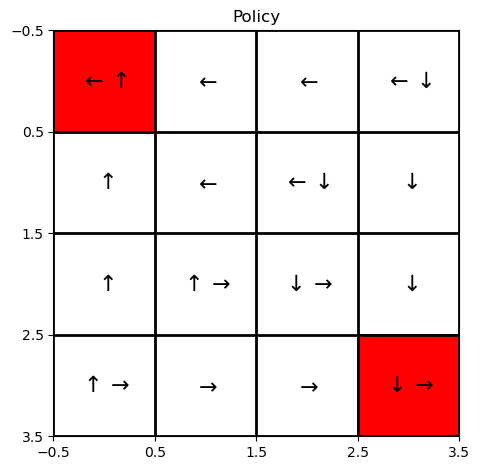


Iteration 2 of Policy Iteration algorithm


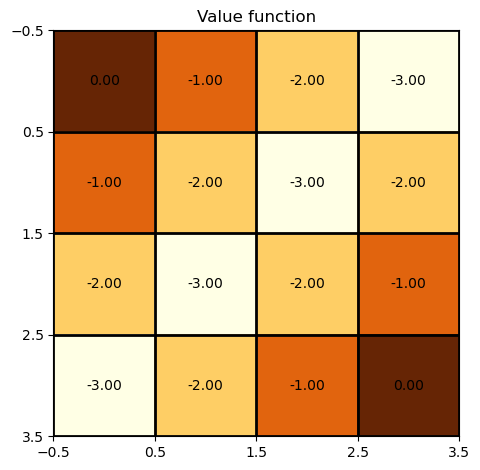


The Policy Evaluation algorithm converged after 4 iterations


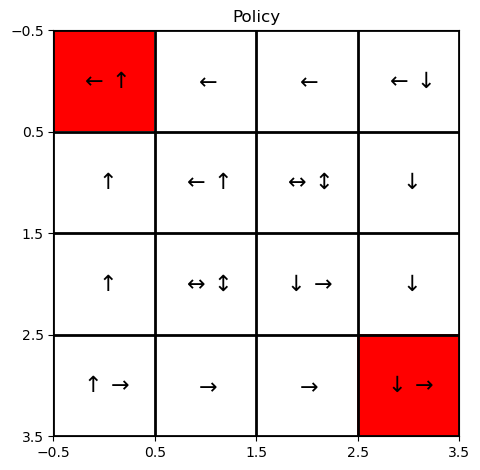


Iteration 3 of Policy Iteration algorithm


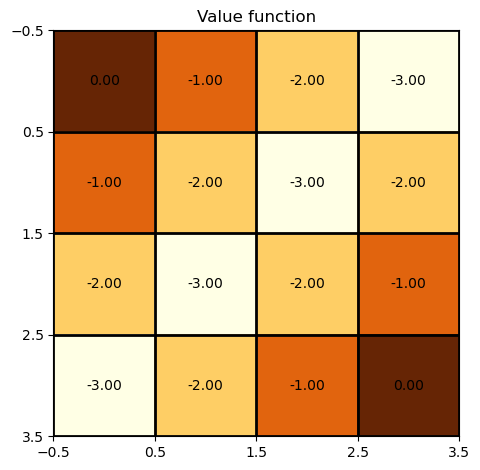


The Policy Evaluation algorithm converged after 1 iterations


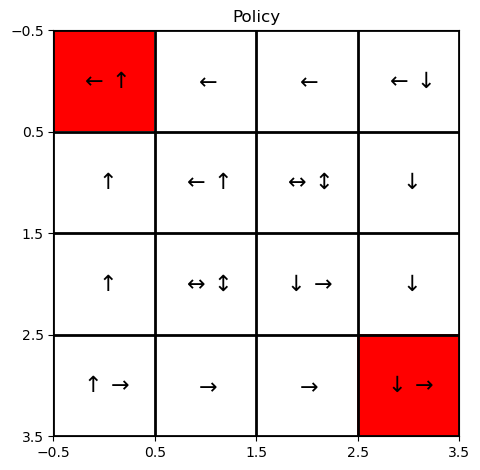


Policy Iteration algorithm converged after 3 steps


In [11]:
n = 4
v0_val = 0
gamma = 1
theta = 0.01
policy_iteration(
        n,
        v0_val,
        gamma,
        theta,
    )

## Value Iteration (Iteration number: 4)

Updated Values after 1 iterations:


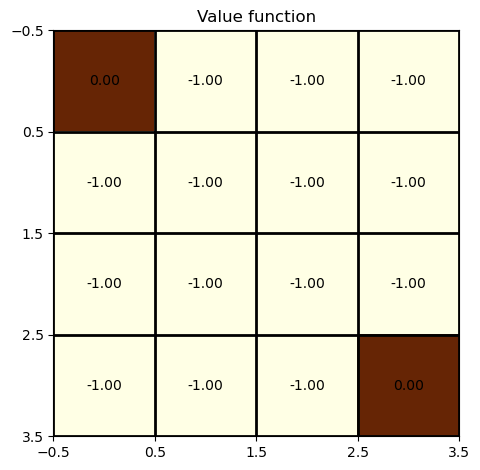


Updated Values after 2 iterations:


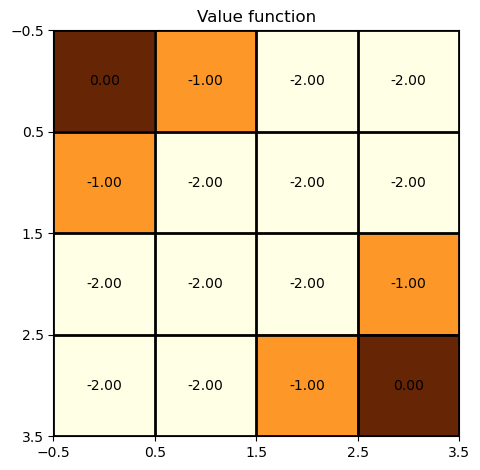


Updated Values after 3 iterations:


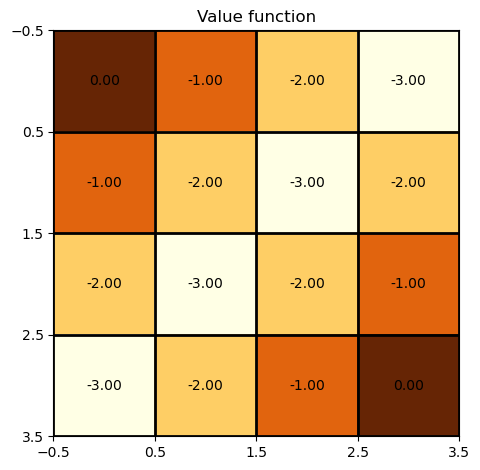


Updated Values after 4 iterations:


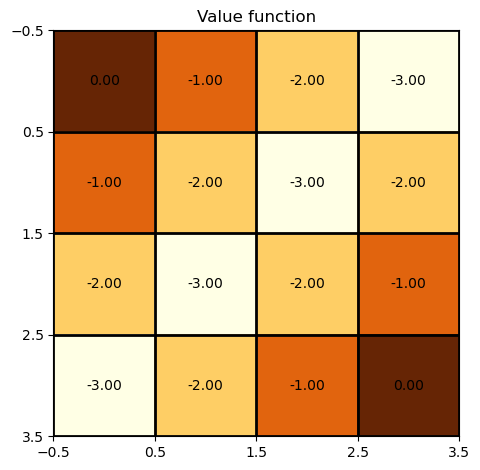

In [12]:
Value = np.zeros(16)
for i in range(4):
    Value = value_update_optimal(Value, gamma)
    print("Updated Values after {} iterations:".format(i + 1))
    # print(Value.reshape(4, 4))
    plot_v_values(Value.reshape(4, 4), 4)
    print()